In [20]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation

# Heat mapping class & functions

In [21]:
# create covid map object
class COVID_MAP:
    def __init__(self, heat_old, position_state, boundaries, xsize, ysize): 
        self.heat_old = heat_old # heat array
        self.position_state = position_state # list of individual people, x y and market for what state they are in healthwise
        self.boundaries = boundaries # array same size as heat array. 0 for open space, 1 for boundaries
        self.xsize = xsize
        self.ysize = ysize
    
    # function to create array of people. Does this 
    def map_position_states(self):
        pos_map = np.zeros((self.xsize, self.ysize))
                           
        for x in self.position_state:
            pos_map[x[0],x[1]] = x[2]
            
        return pos_map
    
    # takes infected people, i.e. = 2, and creates a heat map from this. 
    def heat_source(self): # will add heat source to map based on individuals new position
        sources = np.zeros((self.xsize,self.ysize))
        sources += self.map_position_states()
        sources[sources == 2] = 100 
        sources[sources != 100] = 0
        return sources
    # this is array of 0s and 100s
    
    # this takes each cell moving around and sets heat to 4 cells adjacent
    
    def calculate_heat_new(self): # will calculate single step of heat dispersion
        
        heat_left = np.roll(self.heat_old, 1 , axis = 1)
        heat_right = np.roll(self.heat_old, -1 , axis = 1)
        heat_up = np.roll(self.heat_old, -1 , axis = 0)
        heat_down = np.roll(self.heat_old, 1 , axis = 0)
        
        heat_new = 0.25*(heat_left + heat_right + heat_up + heat_down) # cell heat is the average of adjacent cells
        heat_new = heat_new + self.heat_source()
        heat_new[heat_new > 100] = 100
        
        heat_new[:,0] = heat_new[:,1] # boundary conditions
        heat_new[:,-1] =  heat_new[:,-2]
        heat_new[0,:] = heat_new[1,:]
        heat_new[-1,:] = heat_new[-2,:]
        
        return heat_new
    
     # this visualises the arrays 
    def show_map(self): # creates a heatmap and position map
        # create marker for healthy individuals in heatmap
        heat_map = self.calculate_heat_new()
        pos = self.map_position_states()
        heat_map[pos == 1] = -100
        # create marker for healthy individuals in pos map
        pos_map = self.map_position_states()
        pos_map[pos_map == 1] = -2 
        
        
        #create matplot figure with subplots
        fig, axes = plt.subplots(1, 2, figsize=(15, 5)) 
        
        sns.heatmap(np.transpose(heat_map), ax=axes[0], cbar=False, cmap='icefire', center =0).invert_yaxis() #heatmap
        axes[0].set_title("Heat Map")
        
        #sns.heatmap(pos_map, ax=axes[1], cbar=False, cmap='icefire', center = 0).invert_yaxis() #position heatmap
        #axes[1].set_title("Position Map")
        sns.scatterplot(x=self.position_state[:,0], y=self.position_state[:,1], data=self.position_state, ax=axes[1], hue=self.position_state[:,2], legend=False, palette='coolwarm') #position scatterplot
        axes[1].set_title("Position Map")
        axes[1].set_xlim(0,self.xsize)
        axes[1].set_ylim(0,self.ysize)

# Position & movement function

In [22]:
# position state list. 
# create random integers between these two cells 

def Move(position_state):
        movement = np.random.randint(-1, 2, size = (pop_size, 2))  # creates a random array of -1 to 1 to add to the current positions
        coords = position_state[:,0:2] + movement
        coords[coords < 1] = 1 # prevent movement below x and y axis
        coords[coords[:,0] > (xsize - 2)] = (xsize - 2) # prevent movement beyond x axis
        coords[coords[:,1] > (ysize - 2)] = (ysize - 2) # prevent movement beyond y axis
        # replacing with updated coordinates
        position_state[:,0:2] = coords
        return position_state

# Transmission function

In [23]:
# set up tranmission so that there 2 conditions must be met
# temp greater than 0
# and randomness function

def Transmission(position_state, heat):
    for x in range(len(position_state)):
            if heat[position_state[x,0],position_state[x,1]] > 20 and heat[position_state[x,0],position_state[x,1]] > np.random.randint(0,101):
                position_state[x,2] = 2
    return position_state

# Create Starting Conditions
## This is the input to the code - these would be the global 
## variables

In [24]:
# starting conditions
pop_size = 40 # total number of individuals
xsize = 300  # number of cell or pixels in the xaxis
ysize = 300  # number of cells or pixels in the yaxis
heat = np.zeros((xsize,ysize)) # heat map array, currently all cold
boundary = np.zeros((xsize,ysize)) # boundary array, will have values where there are boundaries, values can dictate behaviour

# Create initial list of individuals

In [25]:
x_pos = np.random.randint(1,xsize-2, size=(pop_size,1))  # random x coordinates in column vector
y_pos = np.random.randint(1,ysize-2, size=(pop_size,1))  # random y coordinates in column vector
state = np.zeros((pop_size,1))
random_states = [1, 2]  # 1 means healthy, 2 means infectious
# the weights specify chance of people having covid
weights = [96, 4] # lists the states and weightings
state = np.transpose([np.array(random.choices(random_states, weights=weights, k=pop_size))]) #randomly picks state using weighting probability, convert to column vector
if np.any(np.where(state == 2)) == False: # checks if we have 0 infected individuals
    state[np.random.randint(0,pop_size)] = 2 # adds 1 infected at random
position_state = np.hstack((x_pos, y_pos, state)) # horizontal stack into 1 array

# Create map instance

In [26]:
#create map instance

# option to have multiple maps here
map1 = COVID_MAP(heat, position_state, boundary, xsize, ysize)

# Iterate map1 instance

In [27]:
i = 0   # total iteration counter 

Total Infected:  4
Total Population:  40
Iterations:  100


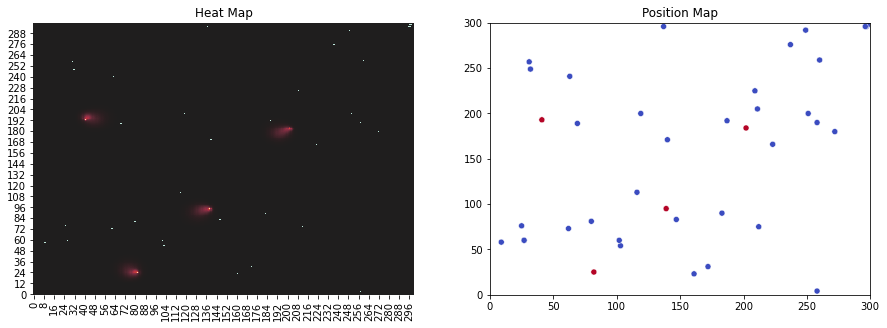

In [28]:
n = 0  # throwaway iterator
while n<100:
    
    Transmission(position_state, heat)
    heat = map1.calculate_heat_new()
    
    # every iteration heat map is moving
    # every iteration covid is spreading 
    # every other iteration people are moving
    
    if (n/2).is_integer(): # only move every other iteration
        Move(position_state)
        
    map1 = COVID_MAP(heat, position_state, boundary, xsize, ysize)

    
    i += 1
    n += 1
 
map1.show_map()
print("Total Infected: ",np.count_nonzero(position_state[:,2] == 2))
print("Total Population: ", pop_size)
print("Iterations: ", i)

# Create some kind of animation

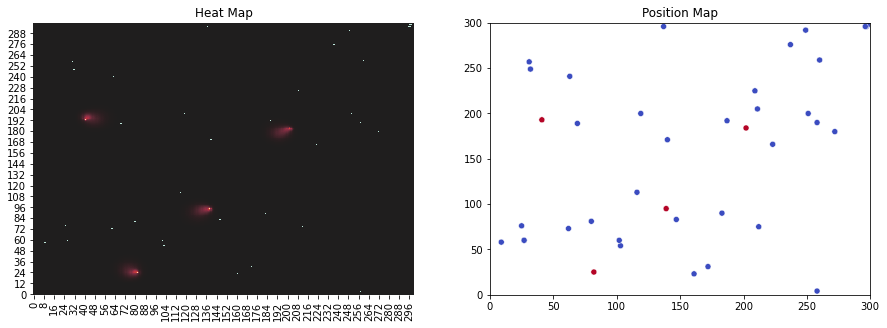

In [29]:
map1.show_map()